In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mols2grid
import helper      
from IPython.display import display

%matplotlib inline

#### Input and format 3D distance matrix

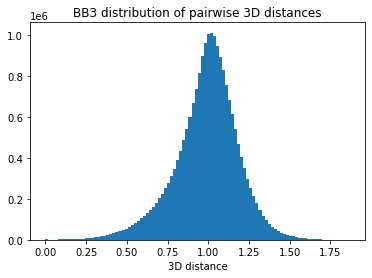

In [3]:
# Load in compound data and 3D similarity matrix
bb3_pactive = pd.read_csv('../data_preparation/output/bb3_pactive.csv')
bb3_sim_3D = np.load('../data_preparation/output/bb3_info.npy')

# Turn values into distance and make matrix symmetric
bb3_dist_3D = 2 - (bb3_sim_3D + bb3_sim_3D.T)/2 
np.fill_diagonal(bb3_dist_3D, 0)

# Visualize distribution of all pairwise 3D distances
plt.hist(bb3_dist_3D.ravel(), bins=100)
plt.xlabel('3D distance')
plt.title('BB3 distribution of pairwise 3D distances')
plt.show()

We find that the distribution of pairwise distances is approximately normal and centered around 1. This makes sense; we would expect the majority of compounds to be an intermediate distance from each other with fewer examples of very similar or dissimilar matches.  

#### Run HDBSCAN clustering

[Documentation for HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html). The nice thing about the algorithm is that it does not require any input parameters to run. However, there are plenty of parameters outlined in the documentation that can be tuned depending on the clustering goal.

One concern with the current clustering results (using default settings) is that it results in almost 2/3 of the building blocks in position 3 being discarded. By further tuning parameters to bring more building blocks into the clustering, we also introduce more noise into the clustering. This is a trade-off we will have to quantify. One idea is to use [silhouette scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), which look at the difference between <em>intra</em>cluster and <em>inter</em>cluster distances for each point. The higher the silhouette score, the more tightly packed points in each cluster are with each other and the further away clusters are from each other. 

Number of clusters: 111
Fraction of clustered compounds: 1733/4572
Adjusted avg silhouette score: 0.150


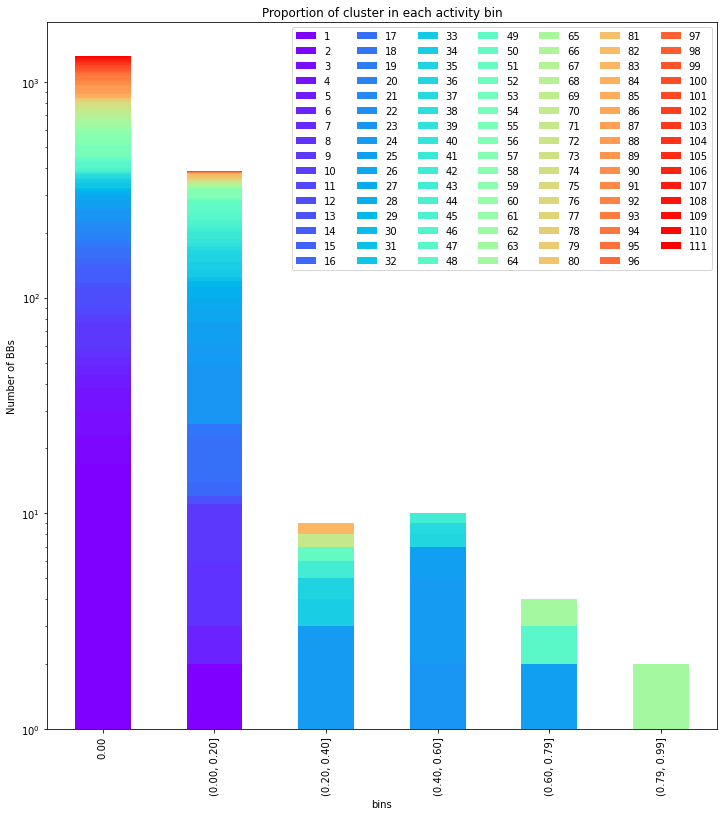

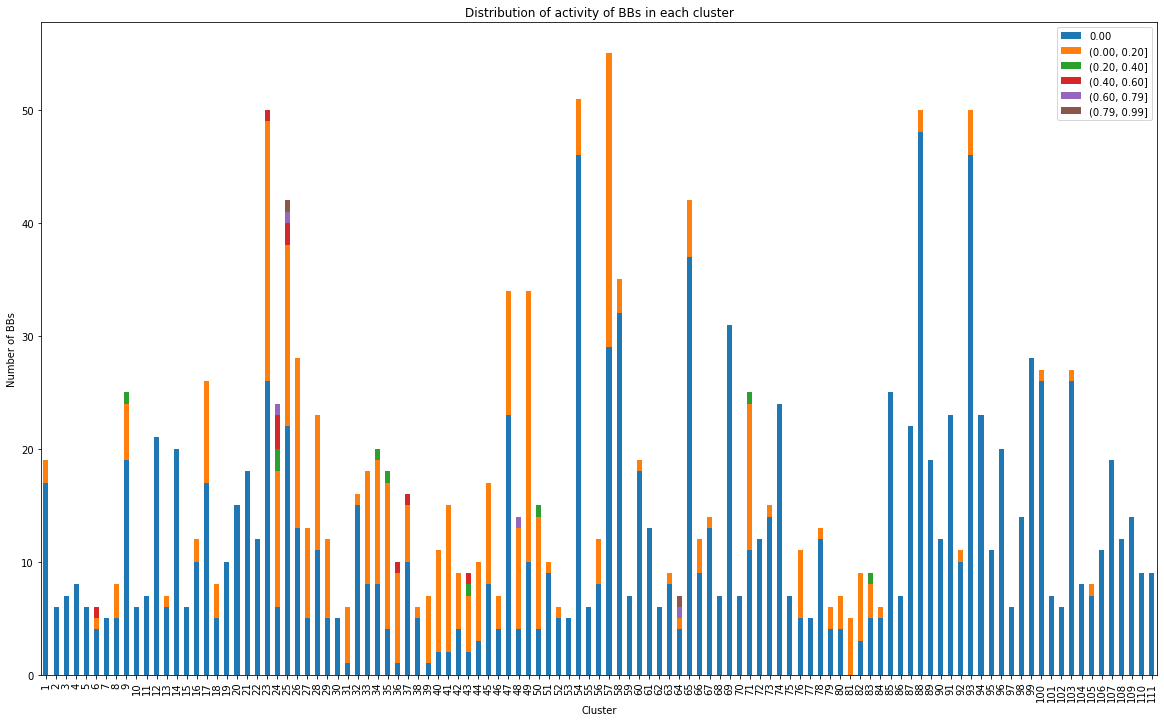

In [4]:
hdb_bb3_3D_data, hdb_bb3_3D_clusters = helper.HDBSCAN(bb3_dist_3D, bb3_pactive)

#### Visualize compounds in each cluster

This tool is quite fun to play around with. Each box corresponds to a cluster. The number at the top of the box is the same as the cluster id in the plots above. Simply click on the box you want to visualize the compounds for and run the next cell to visualize the compounds with the top P(active) values in the cluster. 

To view another cluster, deselect the current selection (or run the mols2grid cell again), select a new cluster and run the next cell. Multiple selections can be made a time, the output will be a mix of the compounds in the different clusters sorted by descending P(active) value.

The visualization function is currently set to display up to 40 compounds. This value can be changed in the `helper.display_cluster_members` function. 

The cluster 0 is for all compounds that could not be clustered by the algorithm. This cluster tends to be substantially larger than the others, so we typically exclude it in the stacked bar plots.  

In [6]:
mols2grid.display(hdb_bb3_3D_clusters, subset=['Cluster', 'img', 'Num'])

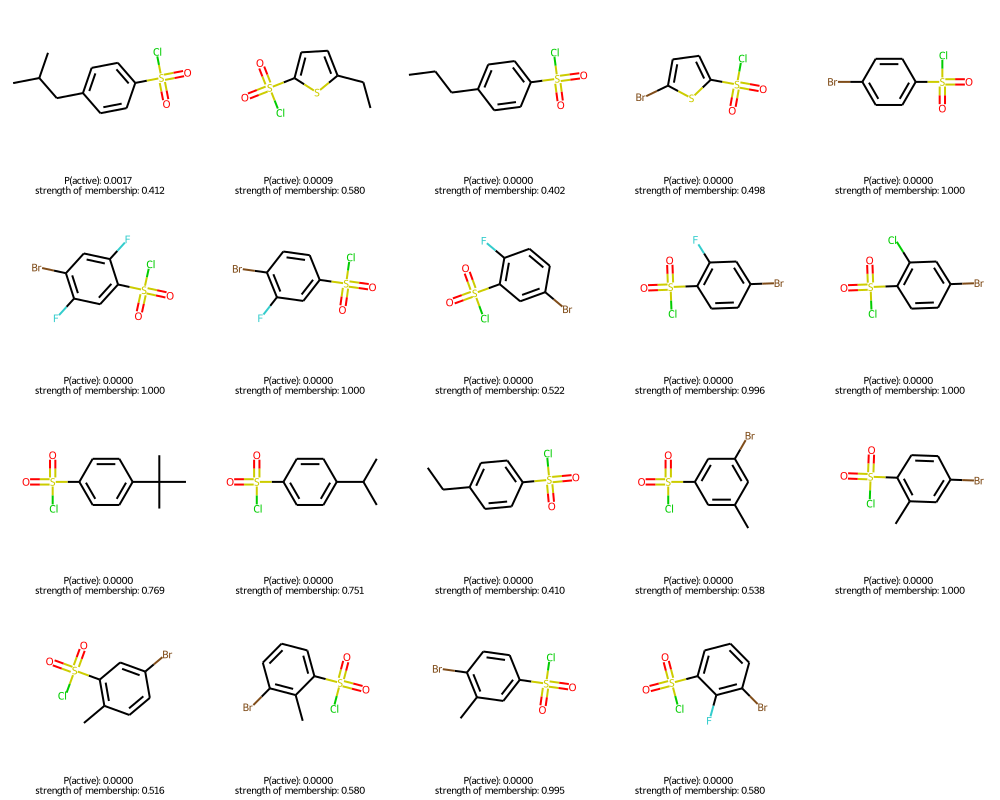

In [26]:
hdbscan_sel = mols2grid.get_selection()
helper.display_cluster_members(hdb_bb3_3D_data, hdbscan_sel, align_mcs=False, hdbscan=True)

In [28]:
#hdb_bb3_3D_data.to_csv('files/hdb_bb3_3D_data.csv', index=False)

### Compare to results from other clustering methods

[DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html): we need to input two parameters into this clustering algorithm, `eps` which specifies the maximum distance two compounds can be from each other and `min_samples` the minimum number of compounds needed to form a cluster. 

We can call a function that performs a grid search of different combinations of the two parameters, stores the cluster ids for each compound for each cluster parameterization in a dictionary and displays the search results. In the visualization, the size of each dot represents the average size of each cluster and the color/number indicates the average silhouette score. As we can see, there is a trade-off between number of compounds clustered and the overall silhouette score (quality of clustering).

We want to choose a setting where both the silhouette score and size of the point are as large as possible. This could be thought of as choosing a point towards the top right corner that does not have a negative score. A negative silhouette score means that most points are not strong fits into the cluster they are assigned to. 

In the below graphic, a reasonable parameterization might be `eps=0.35, m=10`




0.05


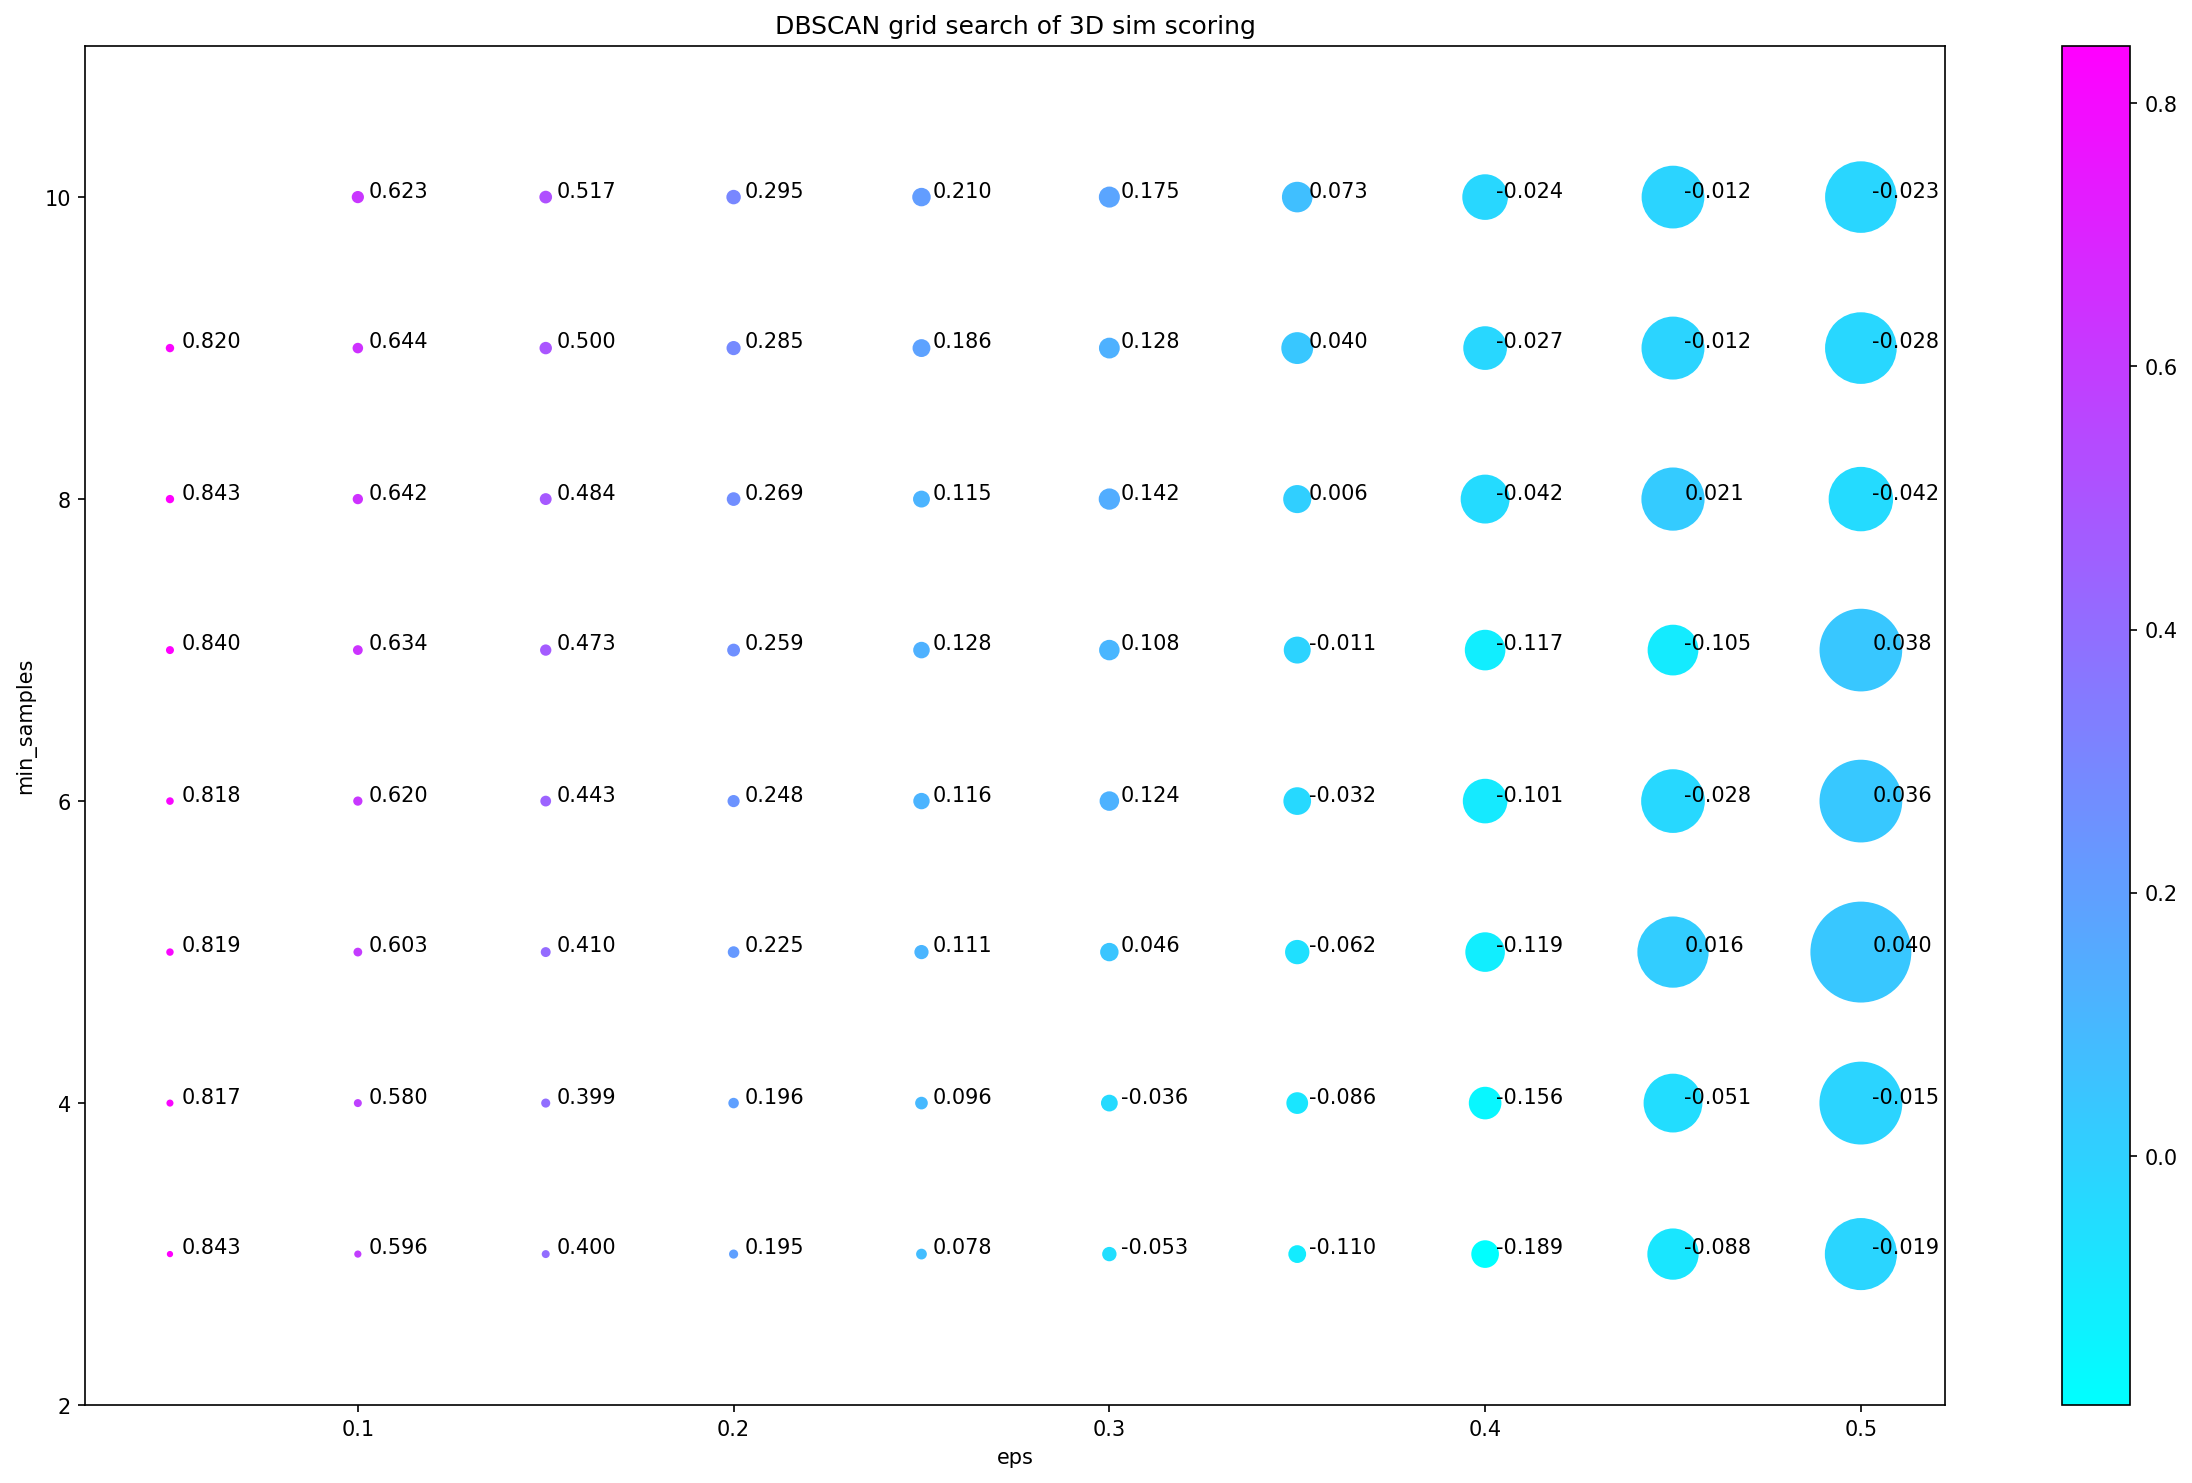

In [8]:
dbscan_dict = helper.dbscan_gridsearch(bb3_dist_3D, eps_range=np.arange(0.05, 0.55, 0.05), min_samp_range=np.arange(3, 11, 1))


In [9]:
# Analyze the cluster assignments that we generated from DBSCAN
db_bb3_3D_data, db_bb3_3D_clusters = helper.cluster_results(bb3_dist_3D, dbscan_dict['eps=0.35, m=10'], bb3_pactive)

Number of clusters: 18
Fraction of clustered compounds: 3373/4572
Adjusted avg silhouette score: 0.054


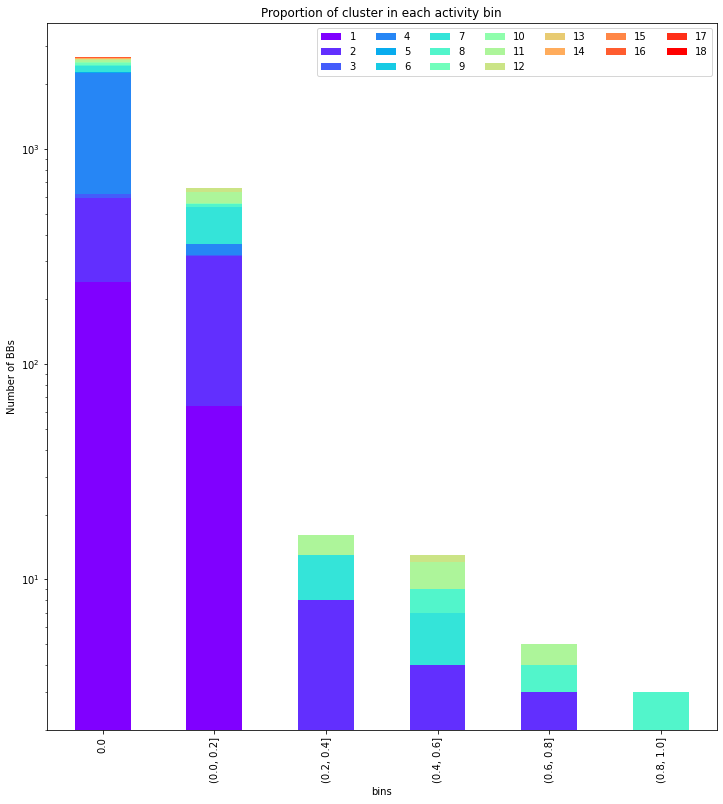

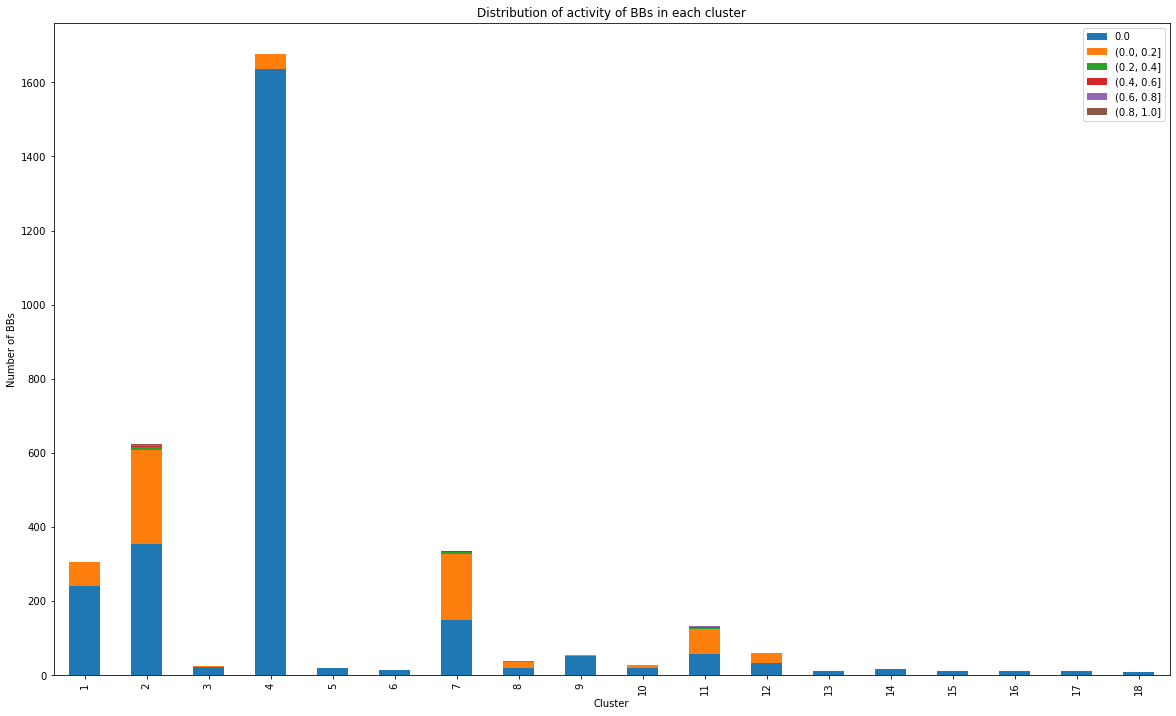

In [10]:
helper.stacked_plots(db_bb3_3D_data, bins_x=True, logy=True)
helper.stacked_plots(db_bb3_3D_data, bins_x=False, logy=False)

In [11]:
mols2grid.display(db_bb3_3D_clusters, subset=['Cluster', 'img', 'Num'])

In [12]:
dbscan_sel = mols2grid.get_selection()
helper.display_cluster_members(db_bb3_3D_data, dbscan_sel, align_mcs=False)

'Nothing selected'

### Butina clustering

[Butina clustering](https://www.rdkit.org/docs/source/rdkit.ML.Cluster.Butina.html): in this algorithm, we just need to set a maximum distance threshold `dist`. The algorithm iterates across the dataset and finds all compounds within `dist` of each other and assigns them to a cluster.

To determine the best distance threshold, we can look at the average silhouette score across clusters as a function of the distance threshold. This is a strictly decreasing trend, since larger distance threshold leads to larger, less compact clusters. However, we want to also consider that larger clusters are desirable to a certain point, since we want as many compounds to be part of our clustering as possible. Thus, we can do an adjusted score where we weight the fraction of the data clustered to the average silhouette score, which ends up being a curve with a visible maximum. 

0.05
0.55


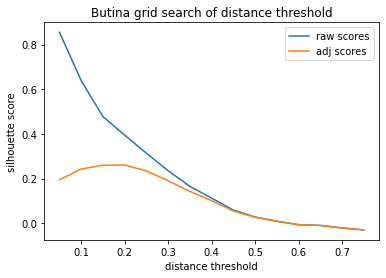

In [13]:
butina_bb3_3D = helper.butina_search(bb3_dist_3D, bb3_pactive, dist_range=np.arange(0.05, 0.80, 0.05))

In [14]:
butina_bb3_3D_data, butina_bb3_3D_clusters = helper.cluster_results(bb3_dist_3D, butina_bb3_3D['dist=0.55'], bb3_pactive)

Number of clusters: 251
Fraction of clustered compounds: 4416/4572
Adjusted avg silhouette score: 0.009


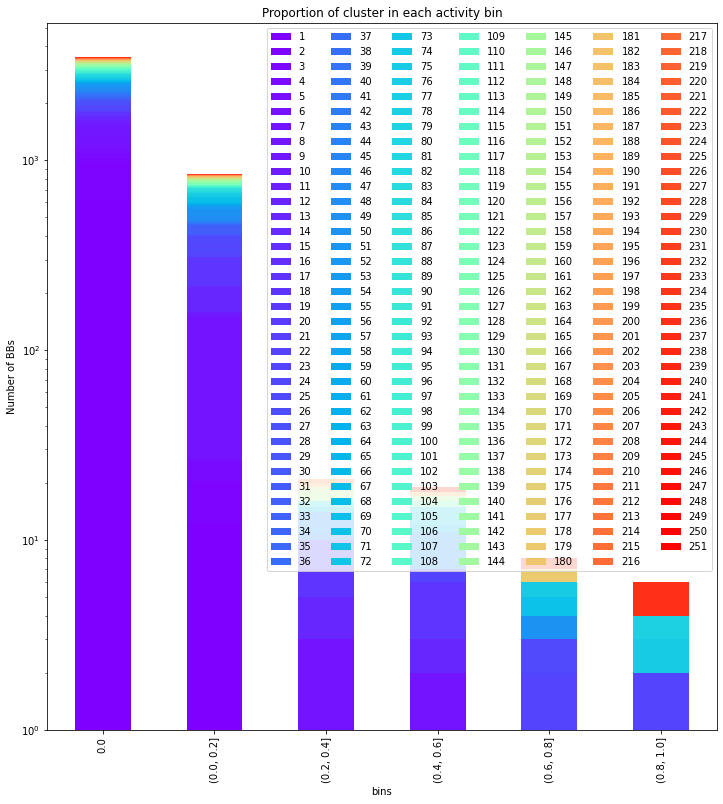

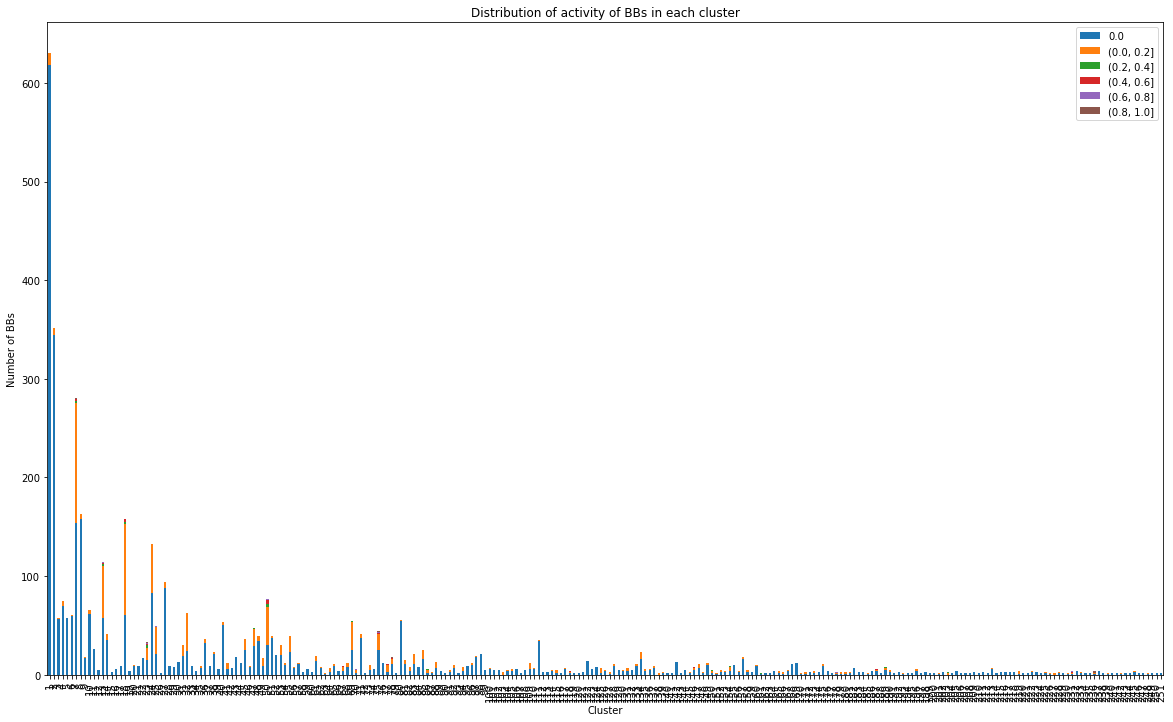

In [15]:
helper.stacked_plots(butina_bb3_3D_data, bins_x=True, logy=True)
helper.stacked_plots(butina_bb3_3D_data, bins_x=False, logy=False)

In [16]:
mols2grid.display(butina_bb3_3D_clusters, subset=['Cluster', 'img', 'Num'])

In [17]:
butina_sel = mols2grid.get_selection()
helper.display_cluster_members(butina_bb3_3D_data, butina_sel, align_mcs=False)

'Nothing selected'

### Repeat for position 2

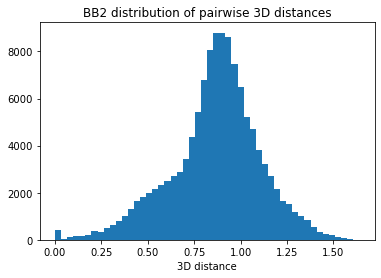

In [5]:
# Load in compound data and 3D similarity matrix
bb2_pactive = pd.read_csv('../data_preparation/output/bb2_pactive.csv')
bb2_sim_3D = np.load('../data_preparation/output/bb2_info.npy')

# Turn values into distance and make matrix symmetric
bb2_dist_3D = 2 - (bb2_sim_3D + bb2_sim_3D.T)/2 
np.fill_diagonal(bb2_dist_3D, 0)

# Visualize distribution of all pairwise 3D distances
plt.hist(bb2_dist_3D.ravel(), bins=50)
plt.xlabel('3D distance')
plt.title('BB2 distribution of pairwise 3D distances')
plt.show()

#### Run HDBSCAN clustering

Number of clusters: 3
Fraction of clustered compounds: 275/349
Adjusted avg silhouette score: 0.163


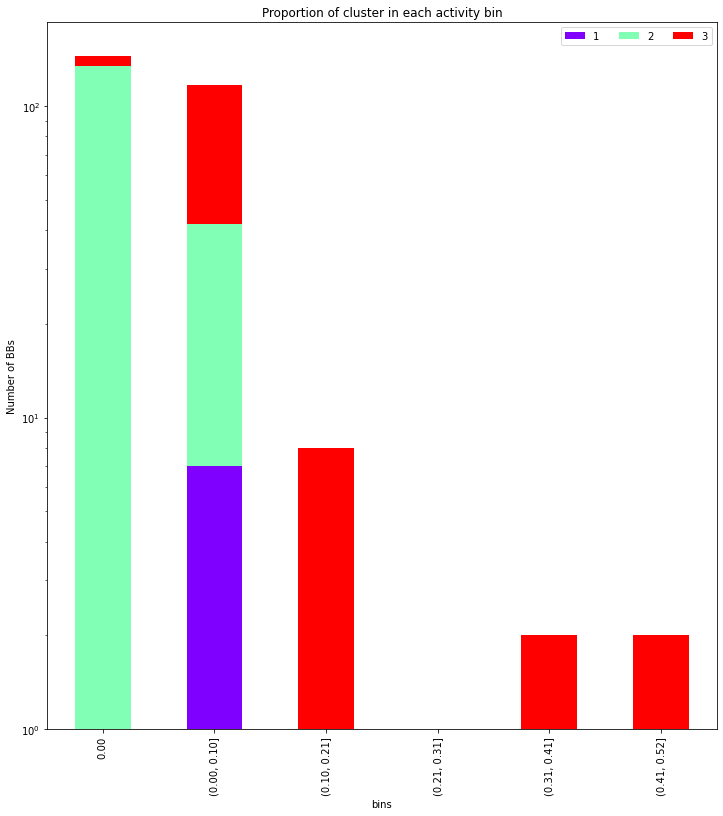

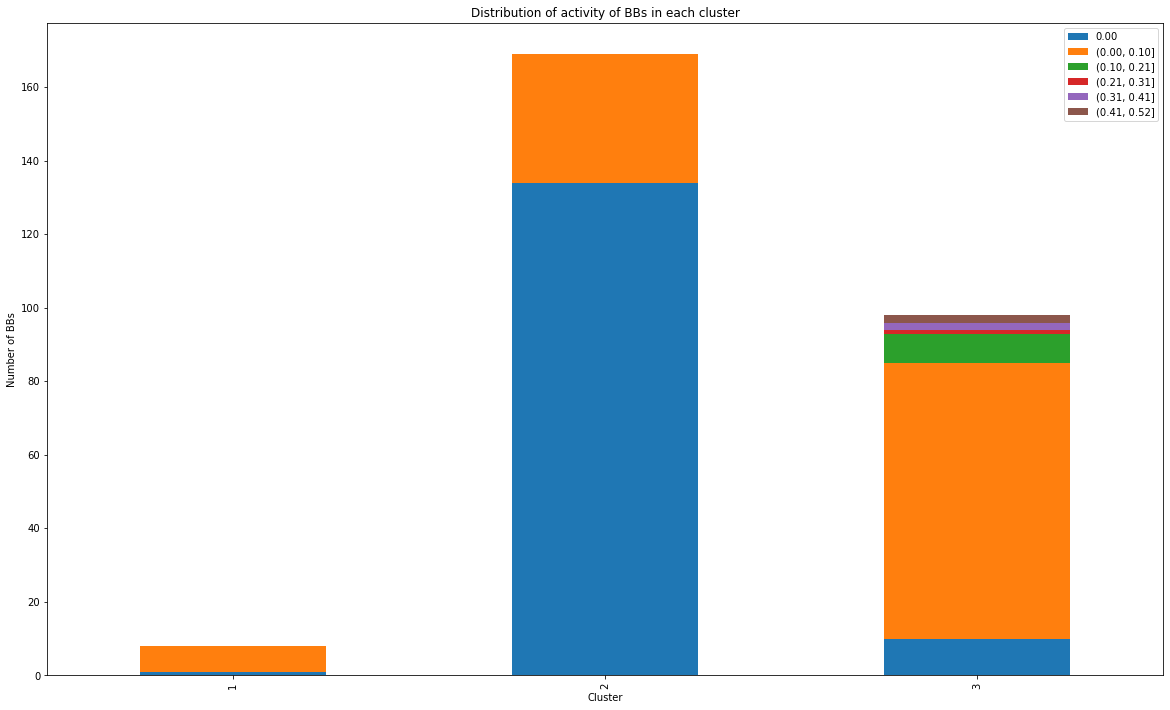

In [6]:
hdb_bb2_3D_data, hdb_bb2_3D_clusters = helper.HDBSCAN(bb2_dist_3D, bb2_pactive)

In [32]:
mols2grid.display(hdb_bb2_3D_clusters, subset=['Cluster', 'img', 'Num'])

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/mols2grid/select.py:26: UserWarning: Overwriting non-empty 'default' grid selection: {1: 'CC1=C(CN)C=C(F)C=C1'}
  f"Overwriting non-empty {name!r} grid selection: {str(overwrite)}"


In [33]:
hdb_sel = mols2grid.get_selection()
helper.display_cluster_members(hdb_bb2_3D_data, hdb_sel, align_mcs=False)

'Nothing selected'

In [34]:
#hdb_bb2_3D_data.to_csv('files/hdb_bb2_3D_data.csv', index=False)

#### DBSCAN

0.10
0.60


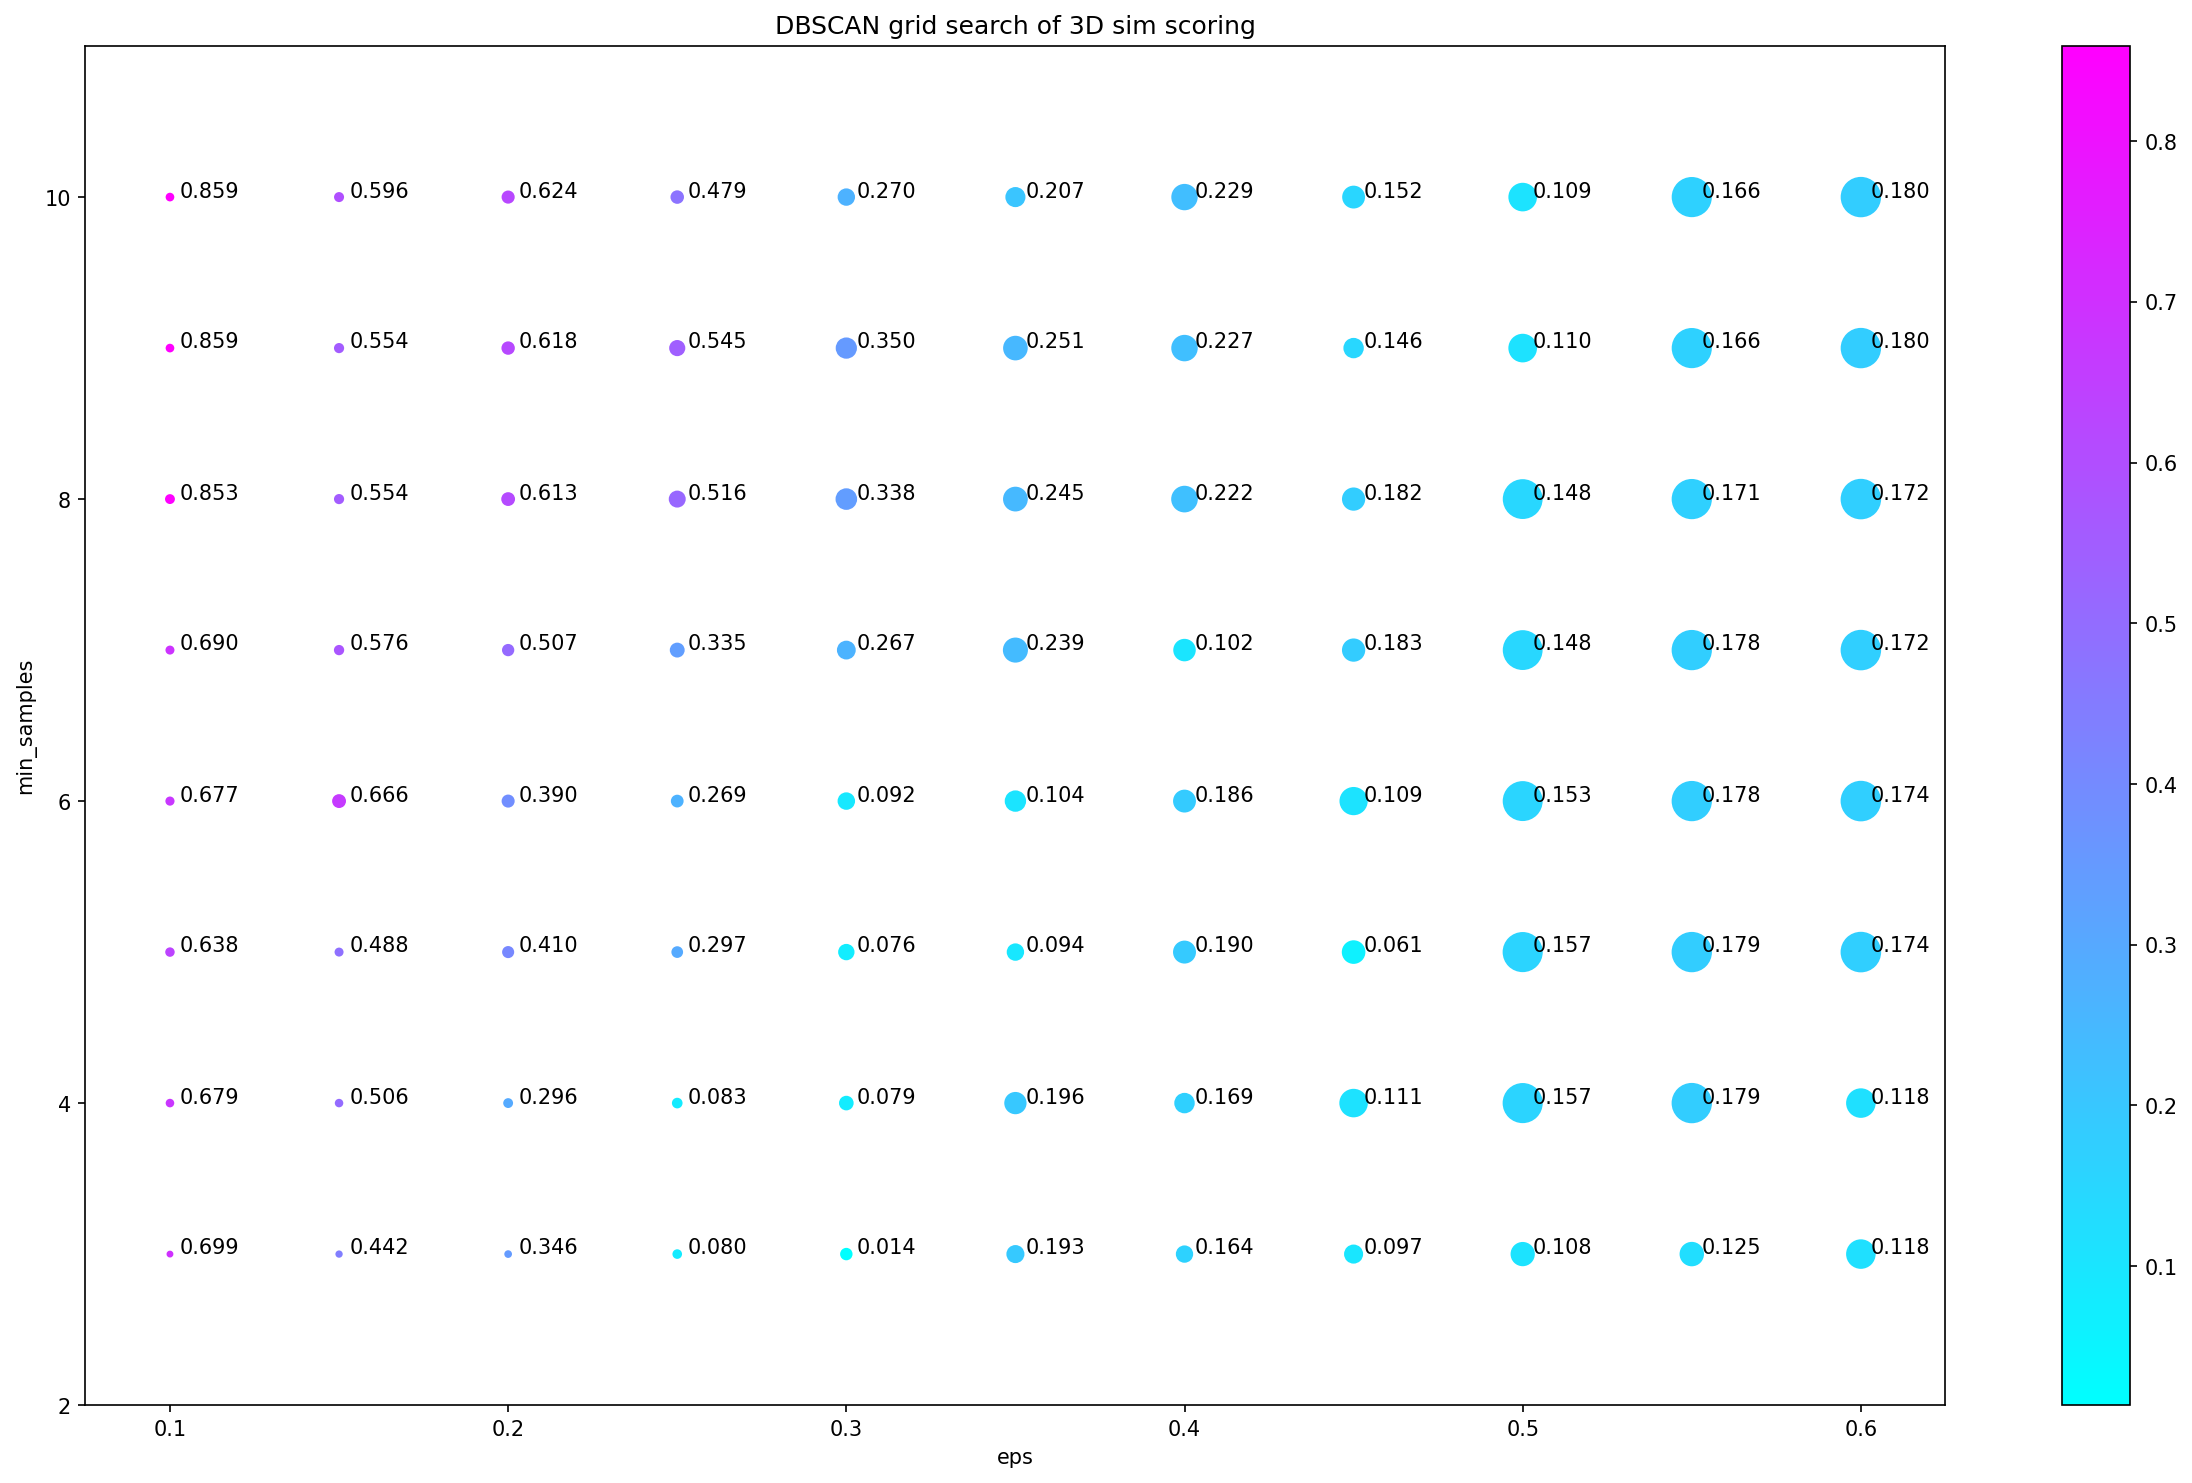

In [6]:
dbscan_bb2_dict = helper.dbscan_gridsearch(bb2_dist_3D, eps_range=np.arange(0.10, 0.65, 0.05), min_samp_range=np.arange(3, 11, 1))


We see that silhouette score stays positive even as average cluster size becomes quite large, but this is the case even when there is only one cluster left. This result is not very meaningful, so we look for a parameterization that gives more clusters and also has a high silhouette score.

In [7]:
db_bb2_3D_data, db_bb2_3D_clusters = helper.cluster_results(bb2_dist_3D, dbscan_bb2_dict['eps=0.40, m=9'], bb2_pactive)


Number of clusters: 2
Fraction of clustered compounds: 274/349
Adjusted avg silhouette score: 0.178


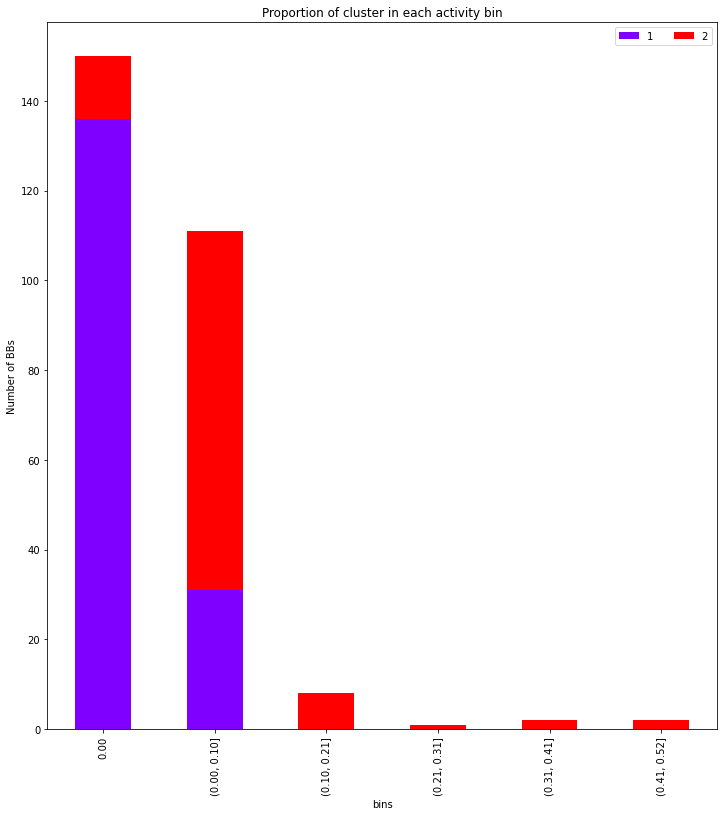

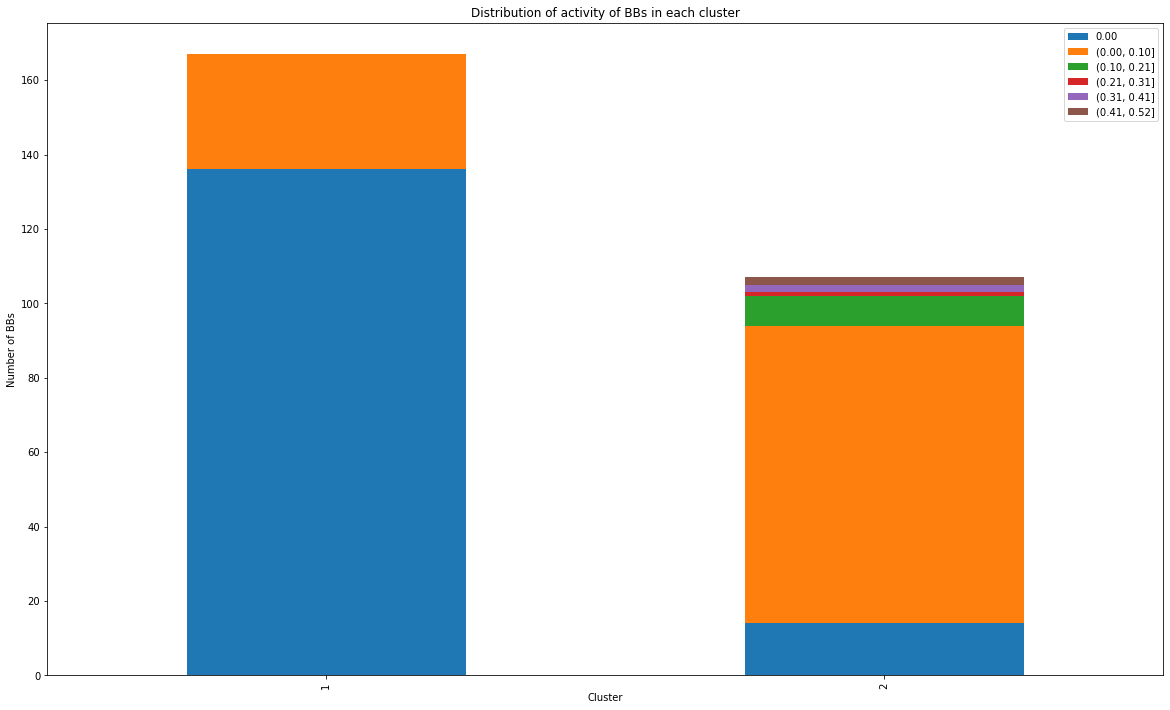

In [8]:
helper.stacked_plots(db_bb2_3D_data, bins_x=True, logy=False)
helper.stacked_plots(db_bb2_3D_data, bins_x=False, logy=False)

In [9]:
mols2grid.display(db_bb2_3D_clusters, subset=['Cluster', 'img', 'Num'])

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/mols2grid/select.py:26: UserWarning: Overwriting non-empty 'default' grid selection: {1: 'Cn1c(cc(n1)C(=O)O)C2CCCNC2'}
  f"Overwriting non-empty {name!r} grid selection: {str(overwrite)}"


/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 40. Change the maxMols value to display more.
  % (maxMols))


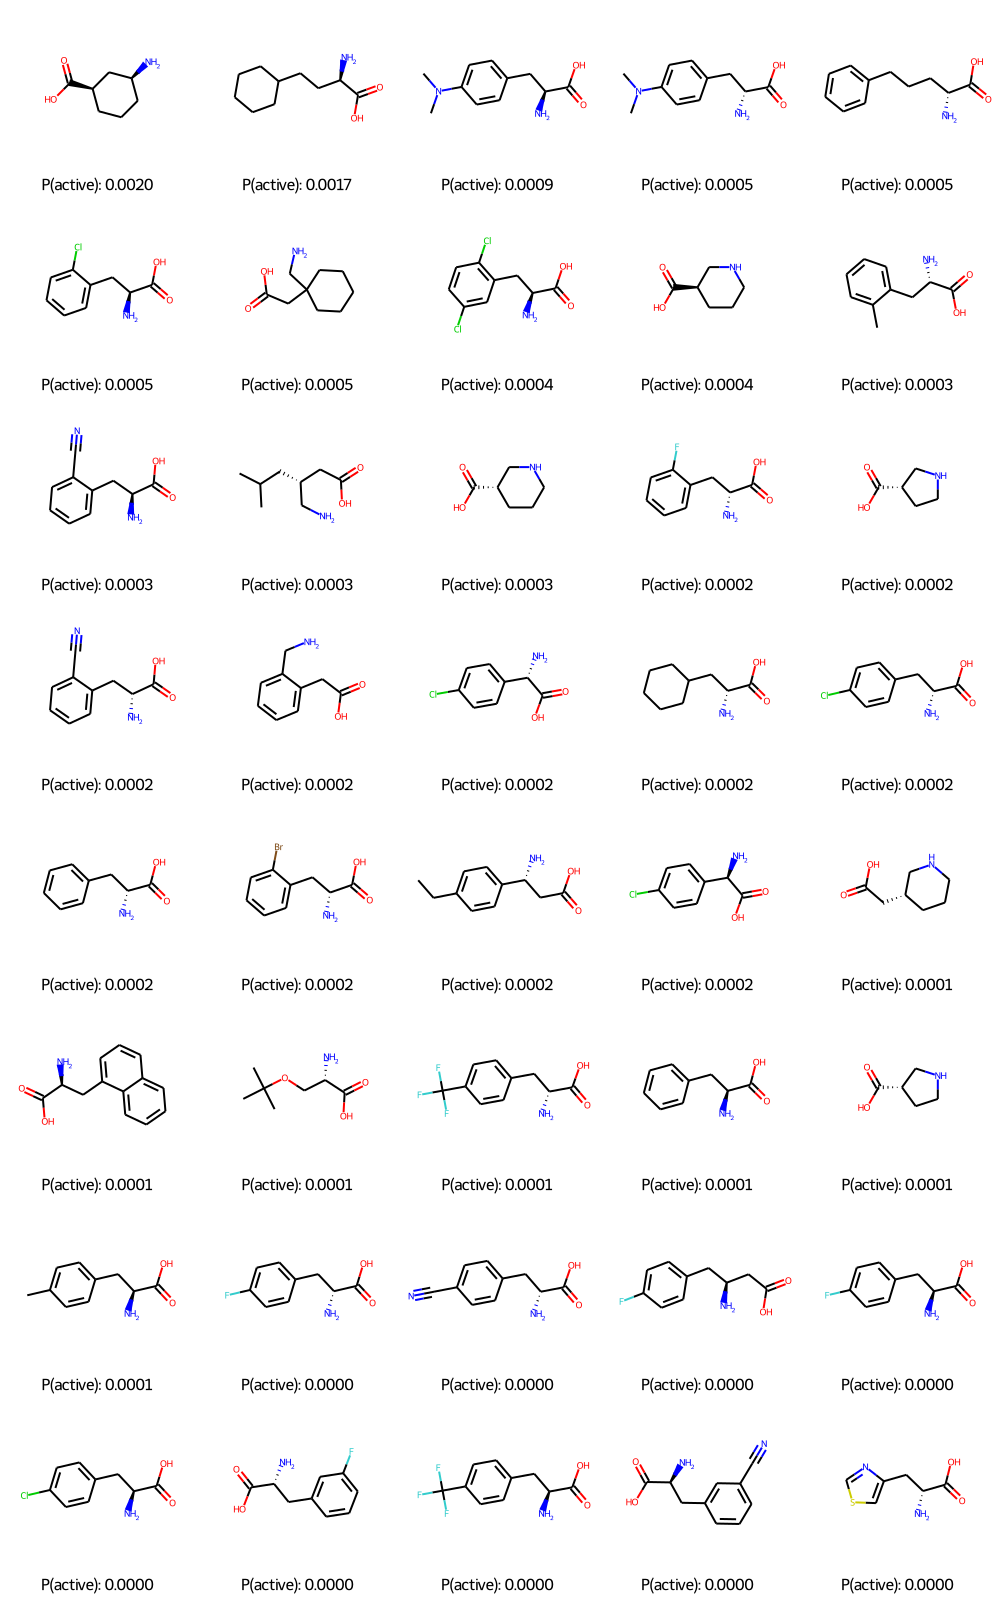

In [10]:
db_sel = mols2grid.get_selection()
helper.display_cluster_members(db_bb2_3D_data, db_sel, align_mcs=False)

#### Butina clustering

0.05
0.55


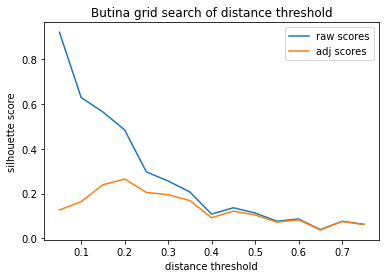

In [11]:
butina_bb2_3D = helper.butina_search(bb2_dist_3D, bb2_pactive, dist_range=np.arange(0.05, 0.80, 0.05))

In [12]:
butina_bb2_3D_data, butina_bb2_3D_clusters = helper.cluster_results(bb2_dist_3D, butina_bb2_3D['dist=0.20'], bb2_pactive)


Number of clusters: 57
Fraction of clustered compounds: 191/349
Adjusted avg silhouette score: 0.265


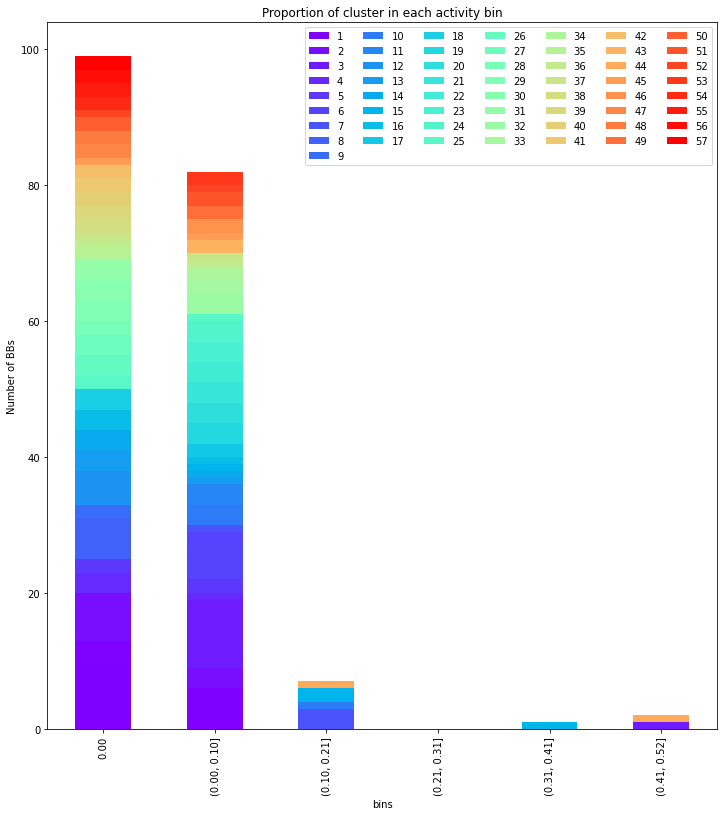

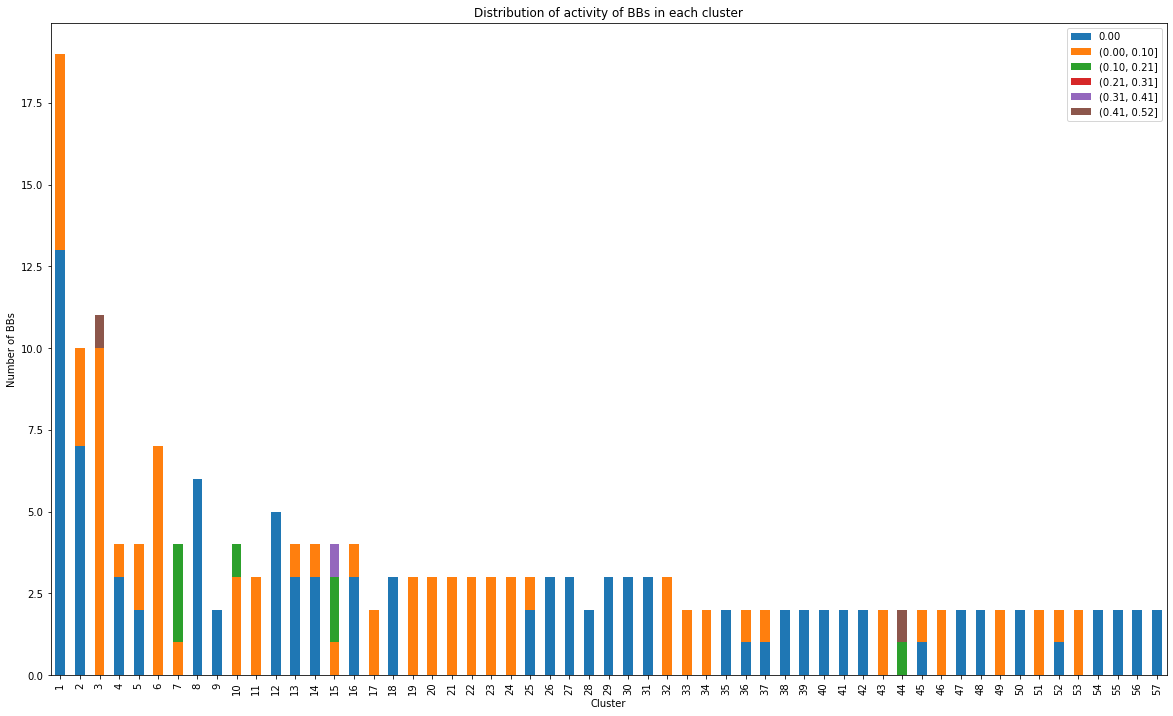

In [13]:
helper.stacked_plots(butina_bb2_3D_data, bins_x=True, logy=False)
helper.stacked_plots(butina_bb2_3D_data, bins_x=False, logy=False)

In [14]:
mols2grid.display(butina_bb2_3D_clusters, subset=['Cluster', 'img', 'Num'])

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/mols2grid/select.py:26: UserWarning: Overwriting non-empty 'default' grid selection: {1: 'C(C#N)[C@H](C(=O)O)N'}
  f"Overwriting non-empty {name!r} grid selection: {str(overwrite)}"


### Repeat for position 1

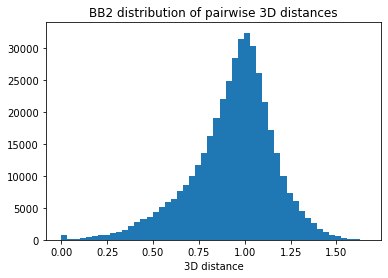

In [7]:
# Load in compound data and 3D similarity matrix
bb1_pactive = pd.read_csv('../data_preparation/output/bb1_pactive.csv')
bb1_sim_3D = np.load('../data_preparation/output/bb1_info.npy')

# Turn values into distance and make matrix symmetric
bb1_dist_3D = 2 - (bb1_sim_3D + bb1_sim_3D.T)/2 
np.fill_diagonal(bb1_dist_3D, 0)

# Visualize distribution of all pairwise 3D distances
plt.hist(bb1_dist_3D.ravel(), bins=50)
plt.xlabel('3D distance')
plt.title('BB2 distribution of pairwise 3D distances')
plt.show()

#### Run HDBSCAN clustering

Number of clusters: 9
Fraction of clustered compounds: 254/645
Adjusted avg silhouette score: 0.135


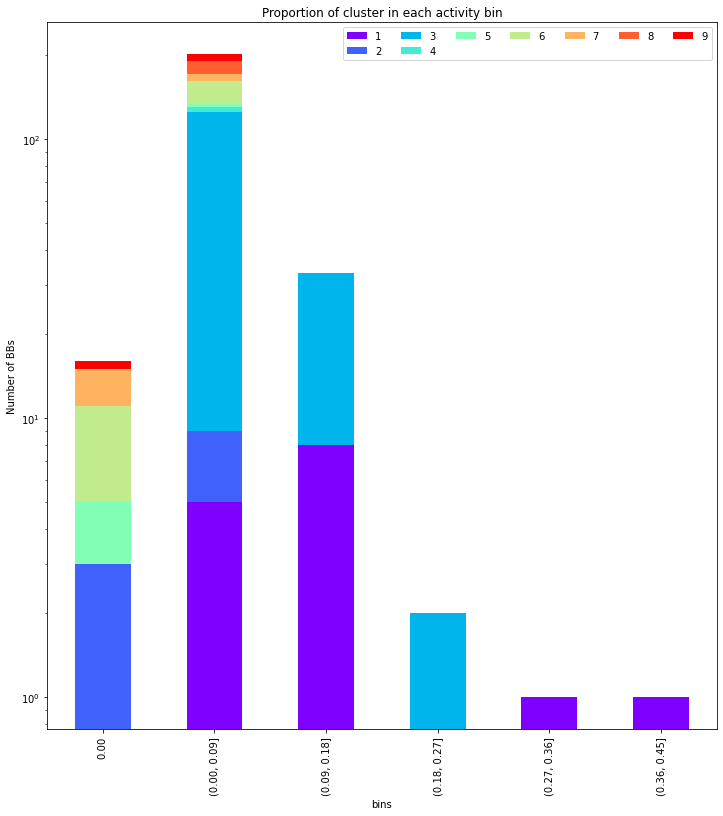

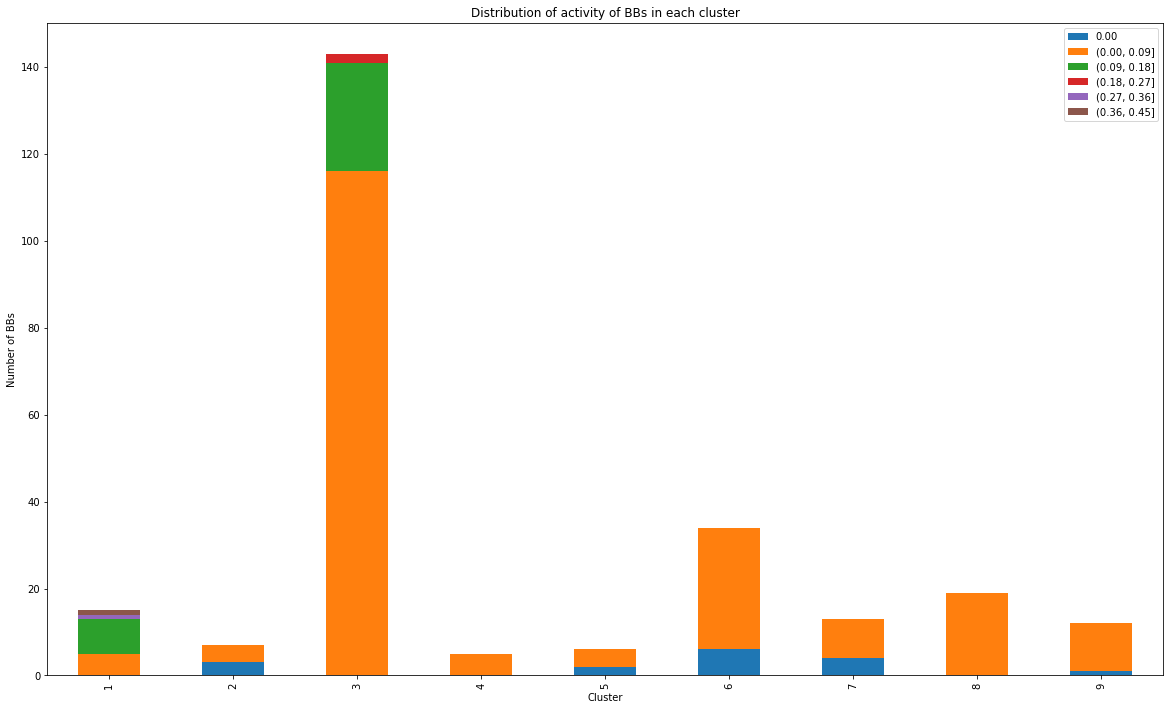

In [8]:
hdb_bb1_3D_data, hdb_bb1_3D_clusters = helper.HDBSCAN(bb1_dist_3D, bb1_pactive)

In [10]:
mols2grid.display(hdb_bb1_3D_clusters, subset=['Cluster', 'img', 'Num'])

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 40. Change the maxMols value to display more.
  % (maxMols))


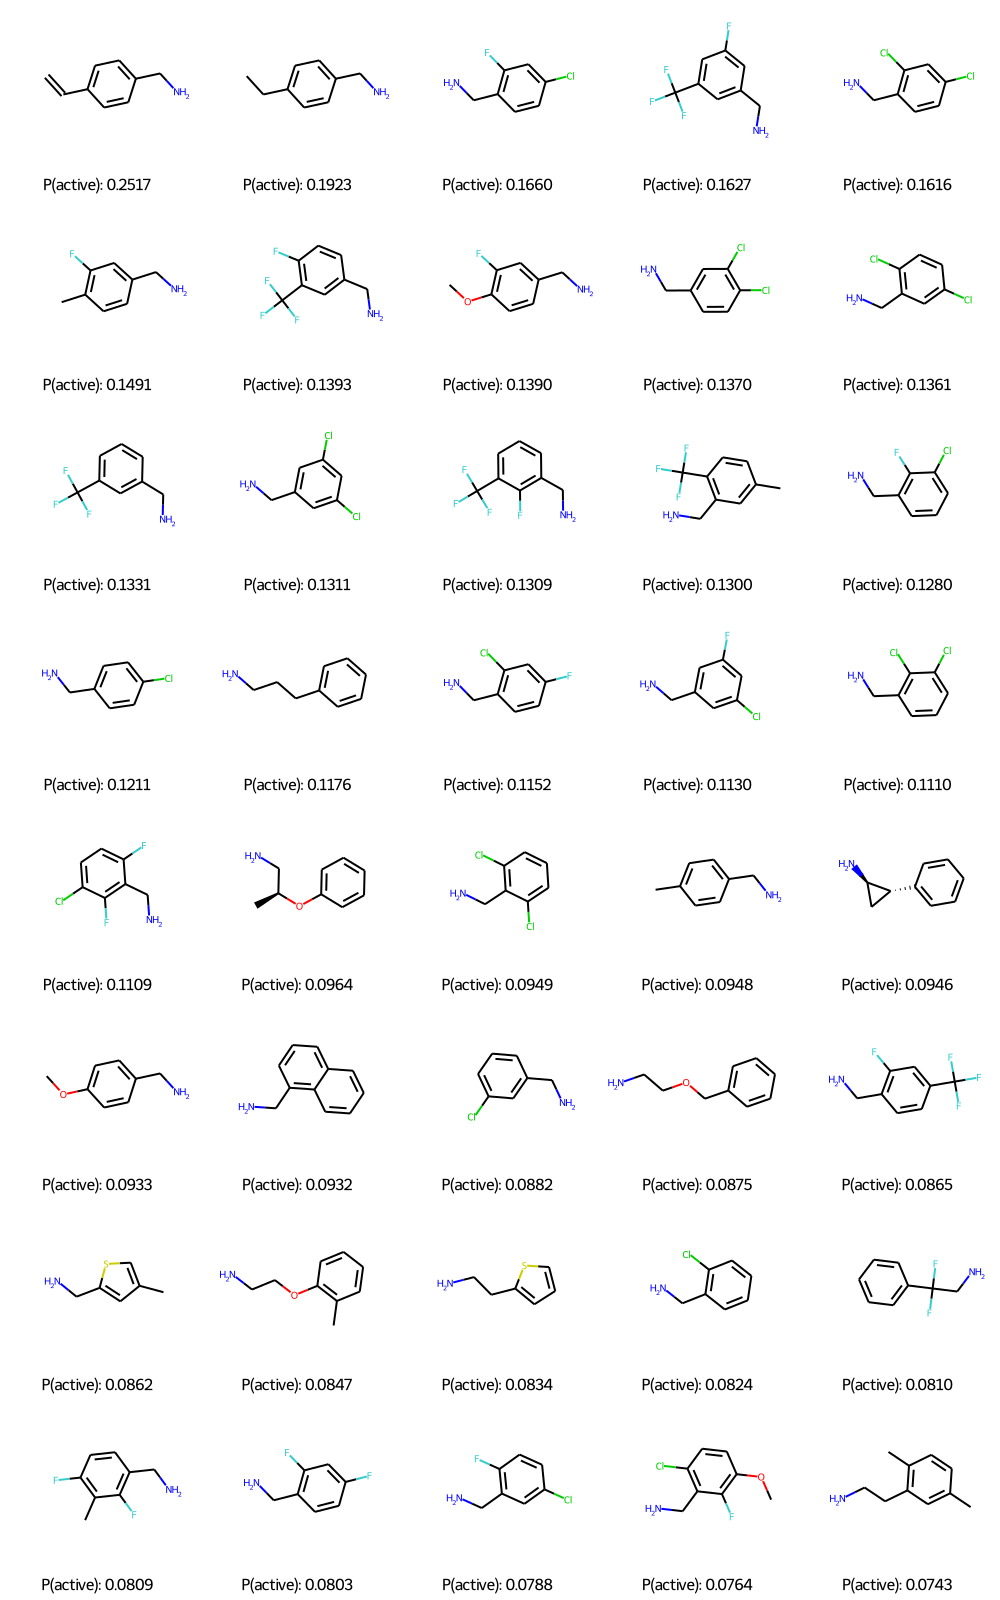

In [12]:
hdb_sel = mols2grid.get_selection()
helper.display_cluster_members(hdb_bb1_3D_data, hdb_sel, align_mcs=False)

In [39]:
#hdb_bb1_3D_data.to_csv('files/hdb_bb1_3D_data.csv', index=False)

#### DBSCAN

0.10
0.60


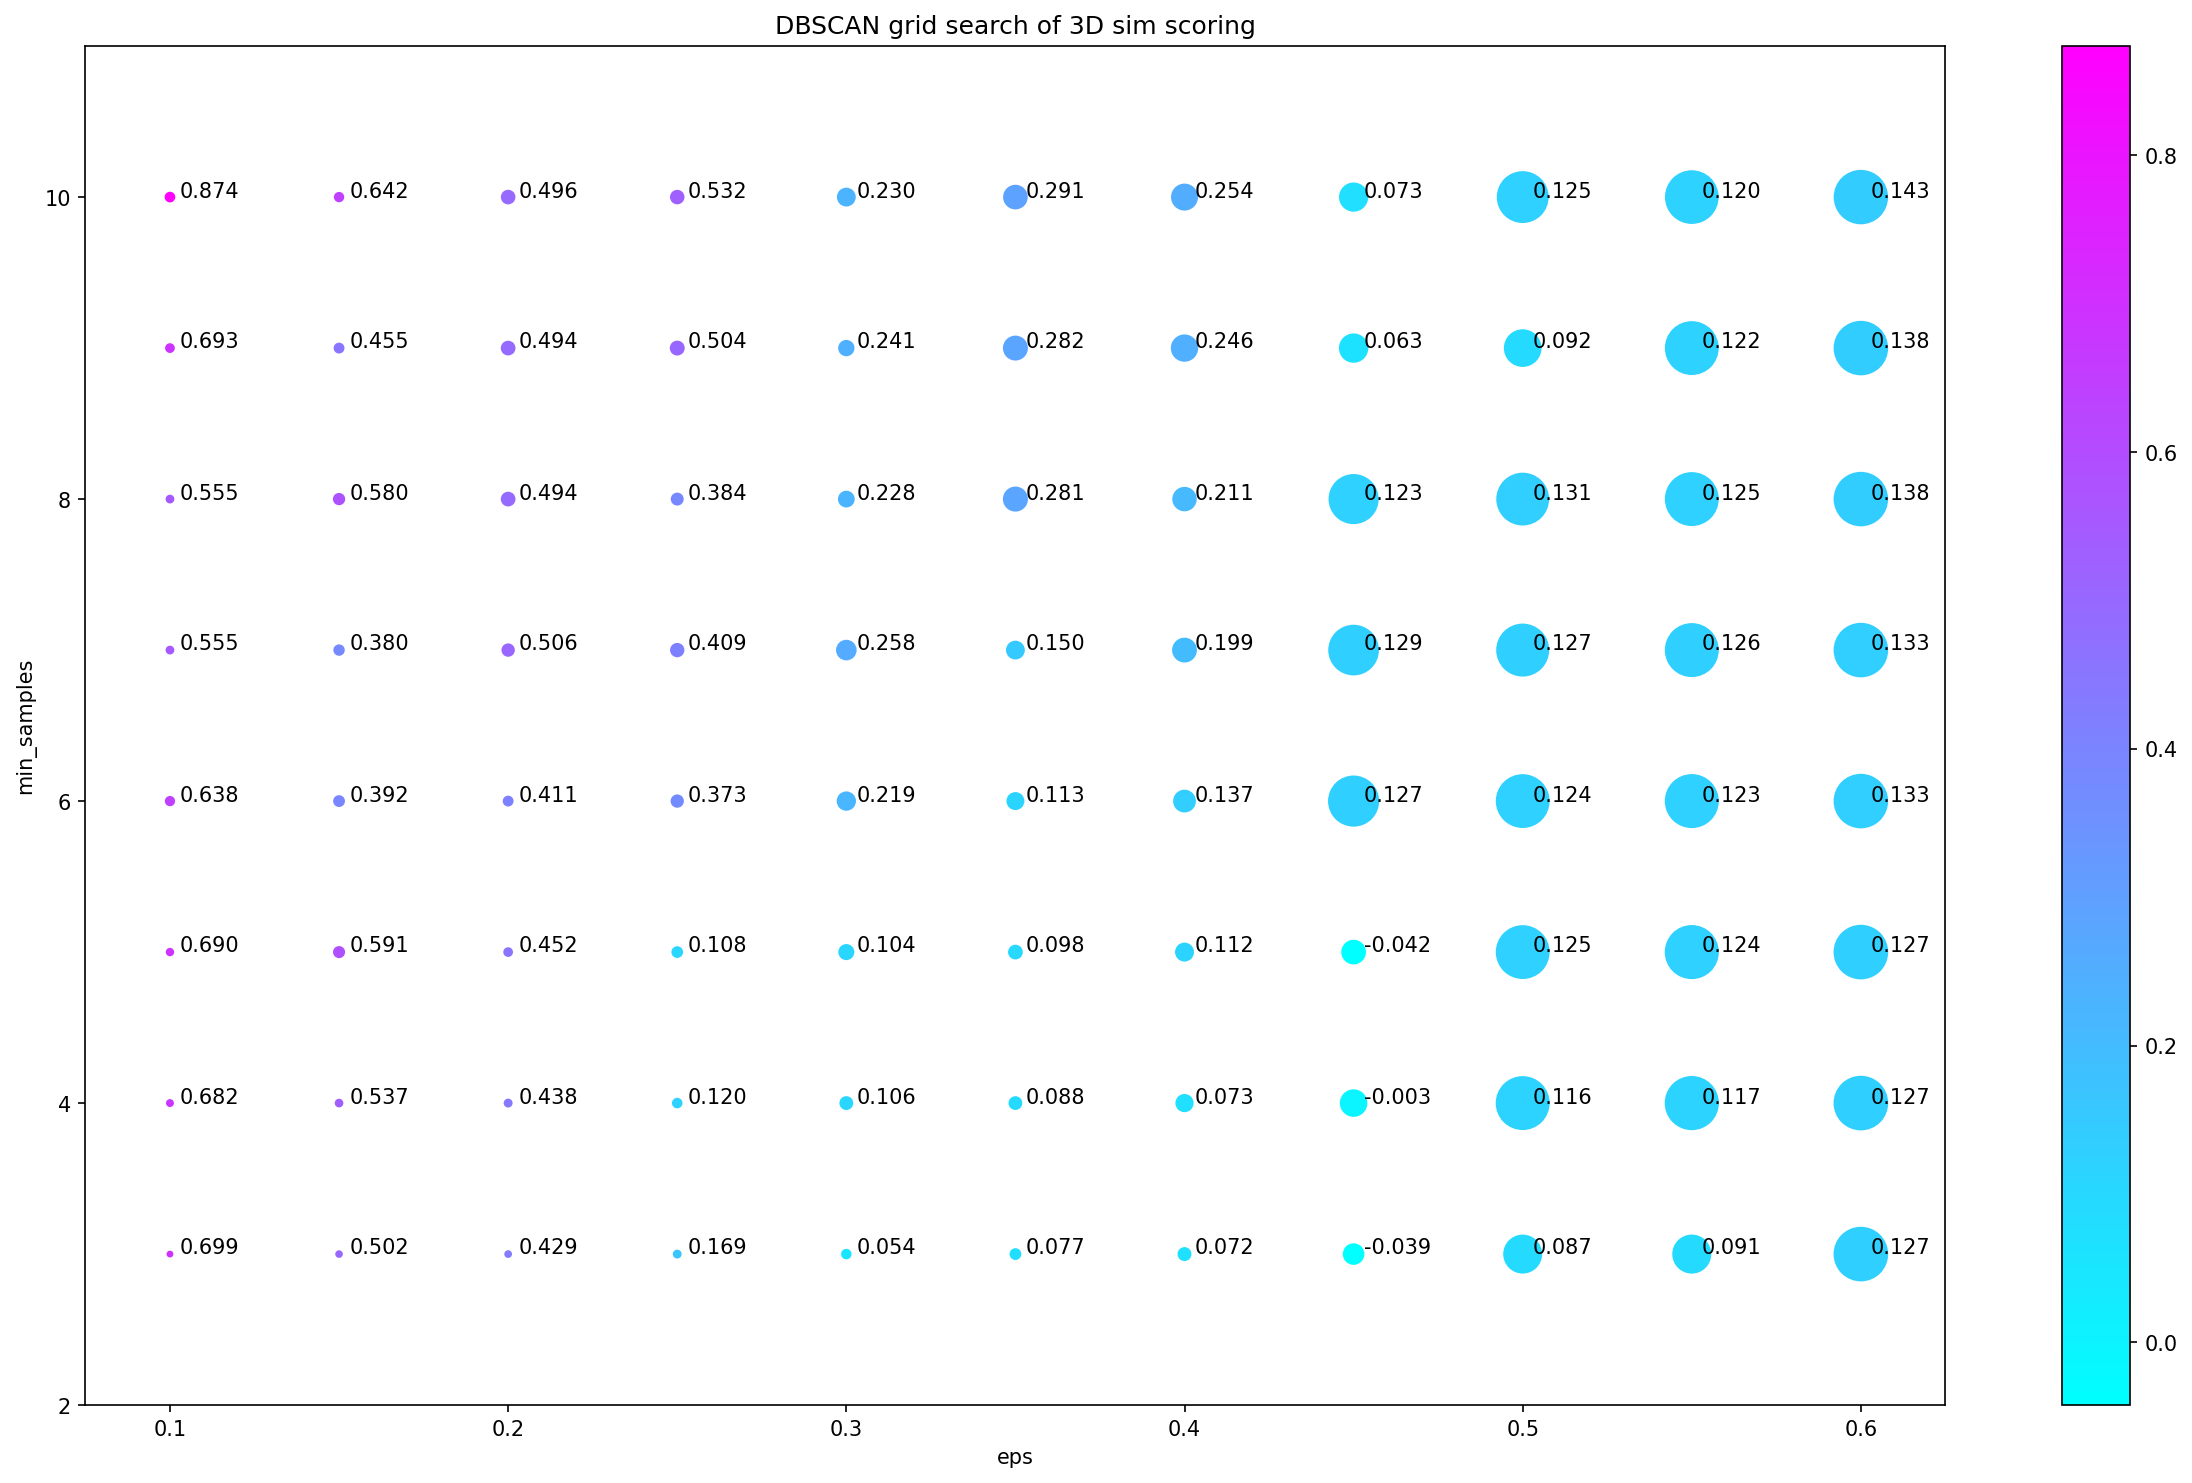

In [6]:
dbscan_bb1_dict = helper.dbscan_gridsearch(bb1_dist_3D, eps_range=np.arange(0.10, 0.65, 0.05), min_samp_range=np.arange(3, 11, 1))


In [7]:
db_bb1_3D_data, db_bb1_3D_clusters = helper.cluster_results(bb1_dist_3D, dbscan_bb1_dict['eps=0.35, m=10'], bb1_pactive)


Number of clusters: 3
Fraction of clustered compounds: 351/645
Adjusted avg silhouette score: 0.158


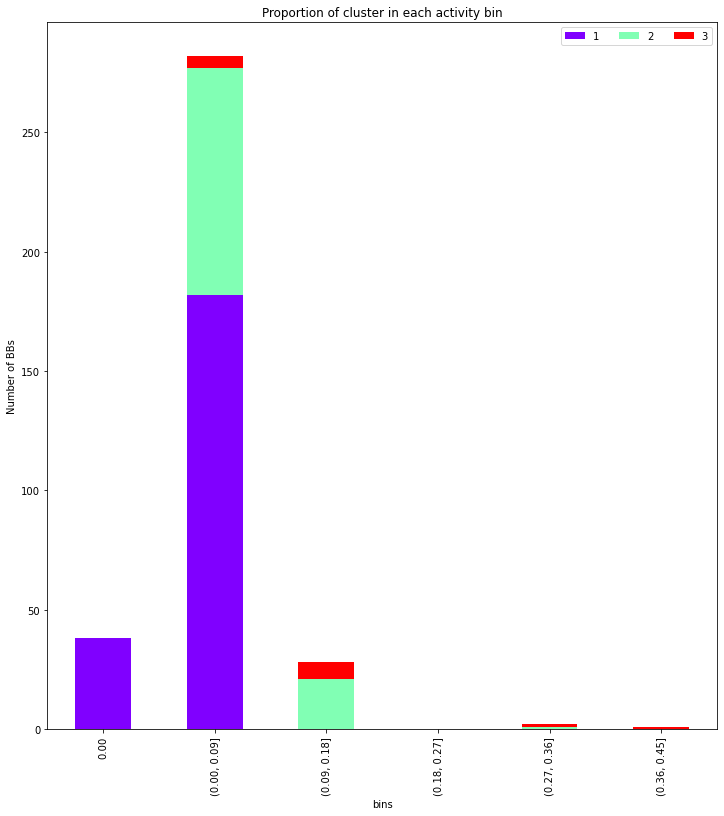

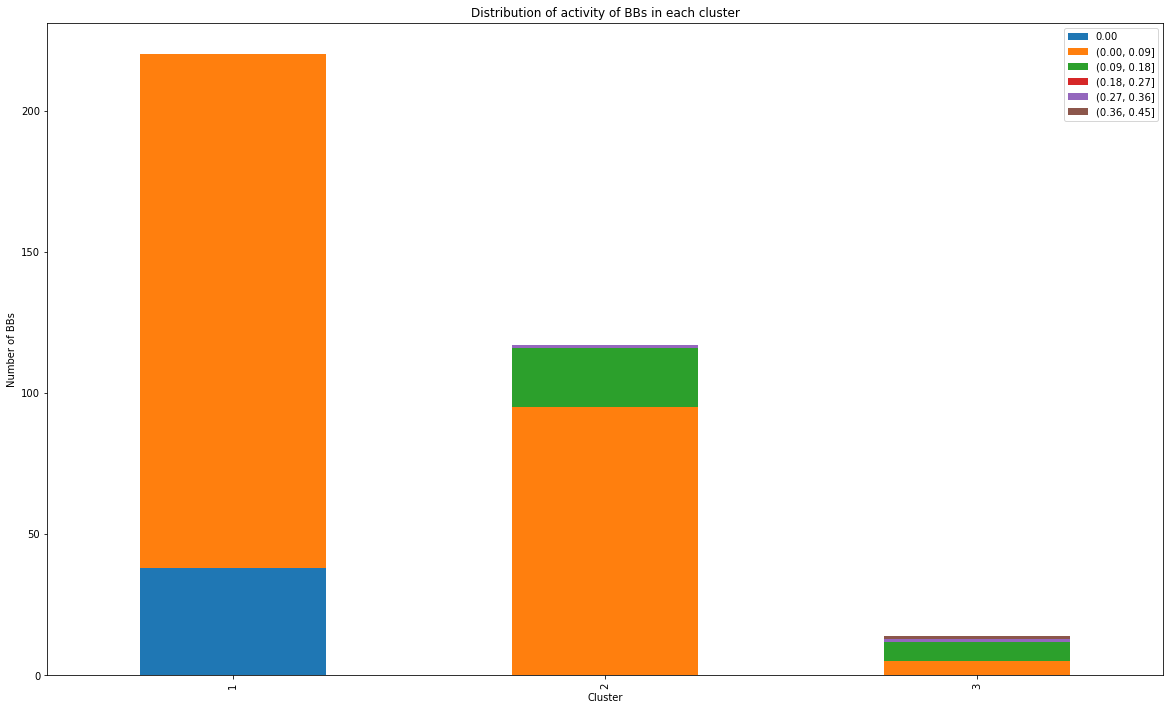

In [8]:
helper.stacked_plots(db_bb1_3D_data, bins_x=True, logy=False)
helper.stacked_plots(db_bb1_3D_data, bins_x=False, logy=False)

In [10]:
mols2grid.display(db_bb1_3D_clusters, subset=['Cluster', 'img', 'Num'])

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/mols2grid/select.py:26: UserWarning: Overwriting non-empty 'default' grid selection: {1: 'CC1=C(CN)OC(C2=CC=CC=C2)=N1'}
  f"Overwriting non-empty {name!r} grid selection: {str(overwrite)}"


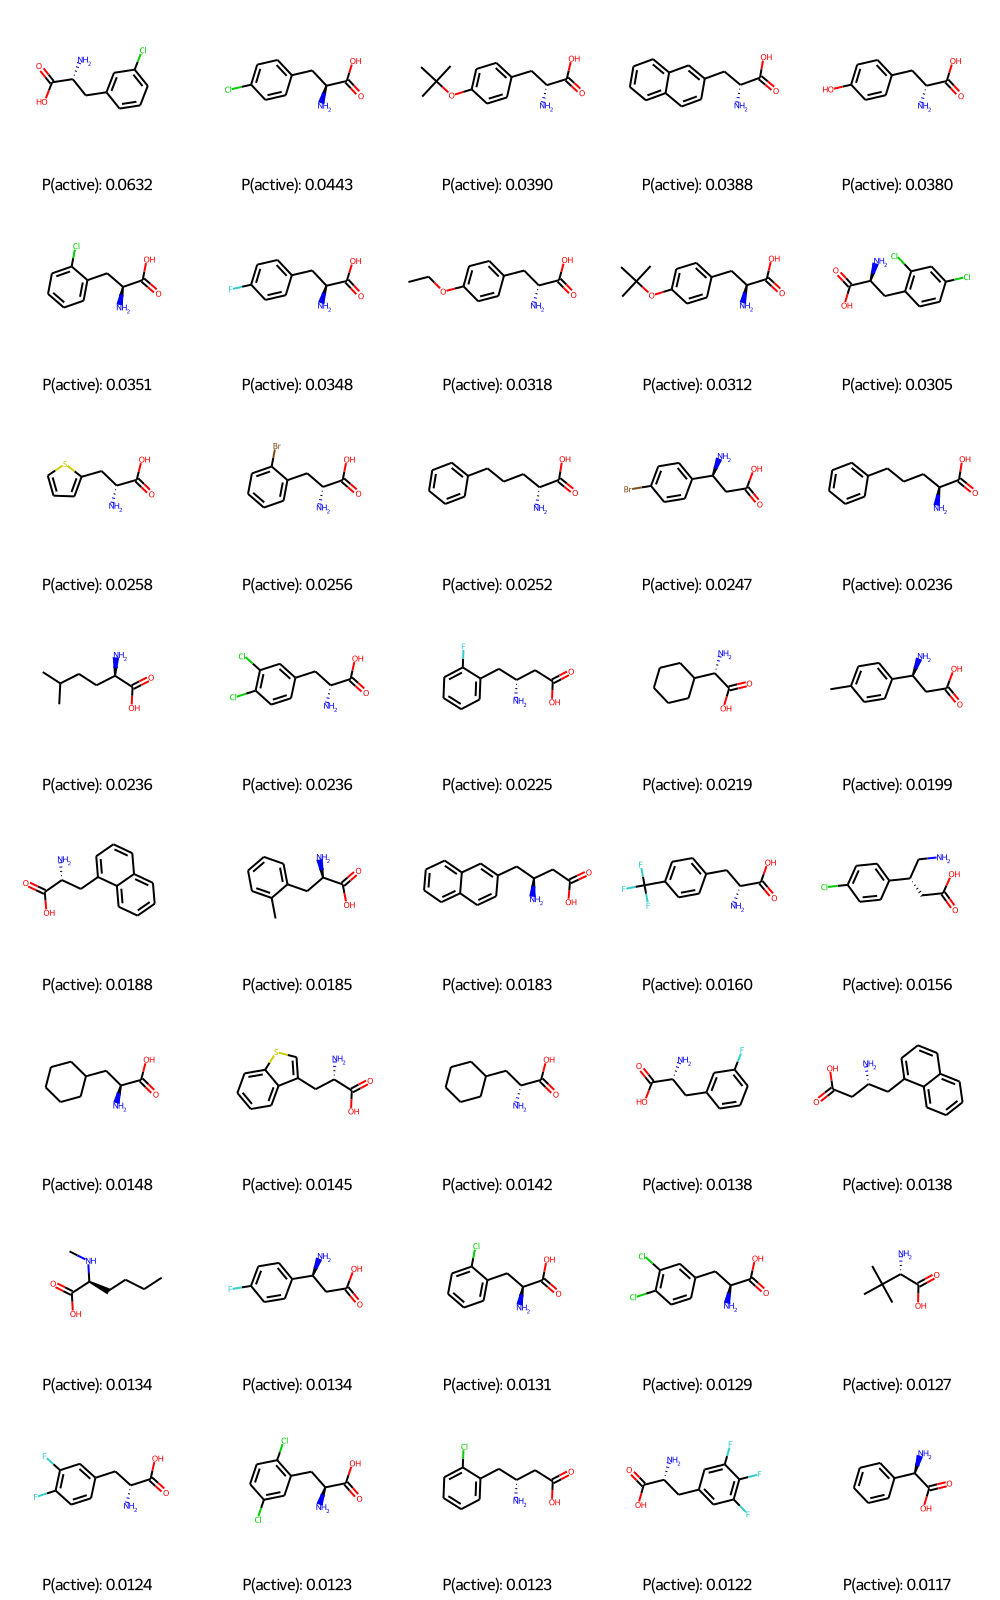

In [16]:
db_sel = mols2grid.get_selection()
helper.display_cluster_members(db_bb1_3D_data, db_sel, align_mcs=False)

#### Butina clustering

0.05
0.55


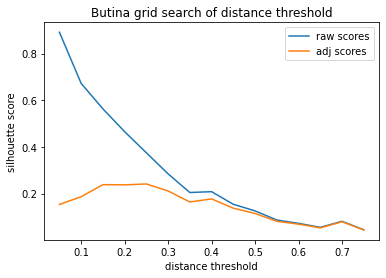

In [17]:
butina_bb1_3D = helper.butina_search(bb1_dist_3D, bb1_pactive, dist_range=np.arange(0.05, 0.80, 0.05))

In [18]:
butina_bb1_3D_data, butina_bb1_3D_clusters = helper.cluster_results(bb1_dist_3D, butina_bb1_3D['dist=0.20'], bb1_pactive)


Number of clusters: 92
Fraction of clustered compounds: 329/645
Adjusted avg silhouette score: 0.237


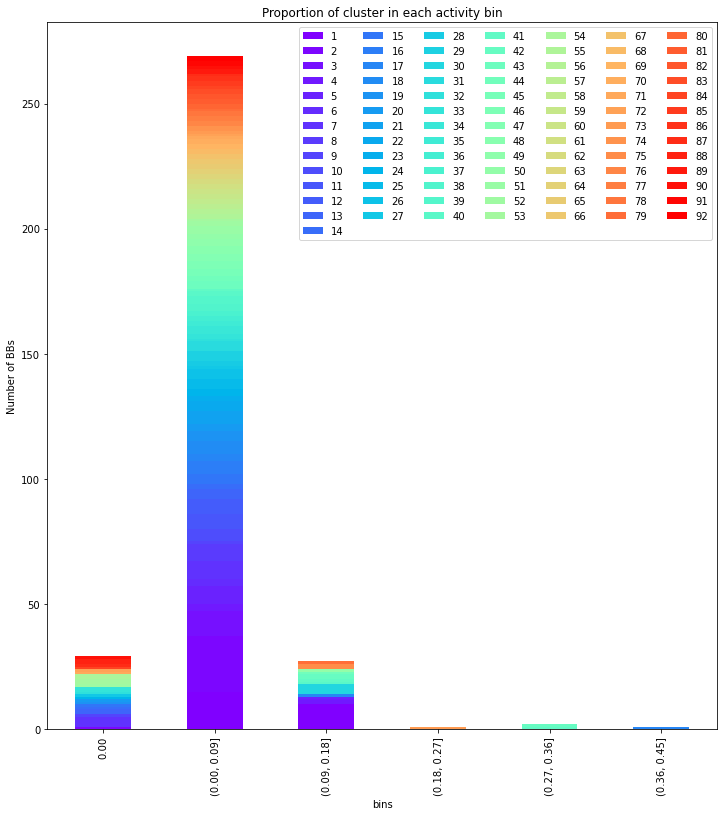

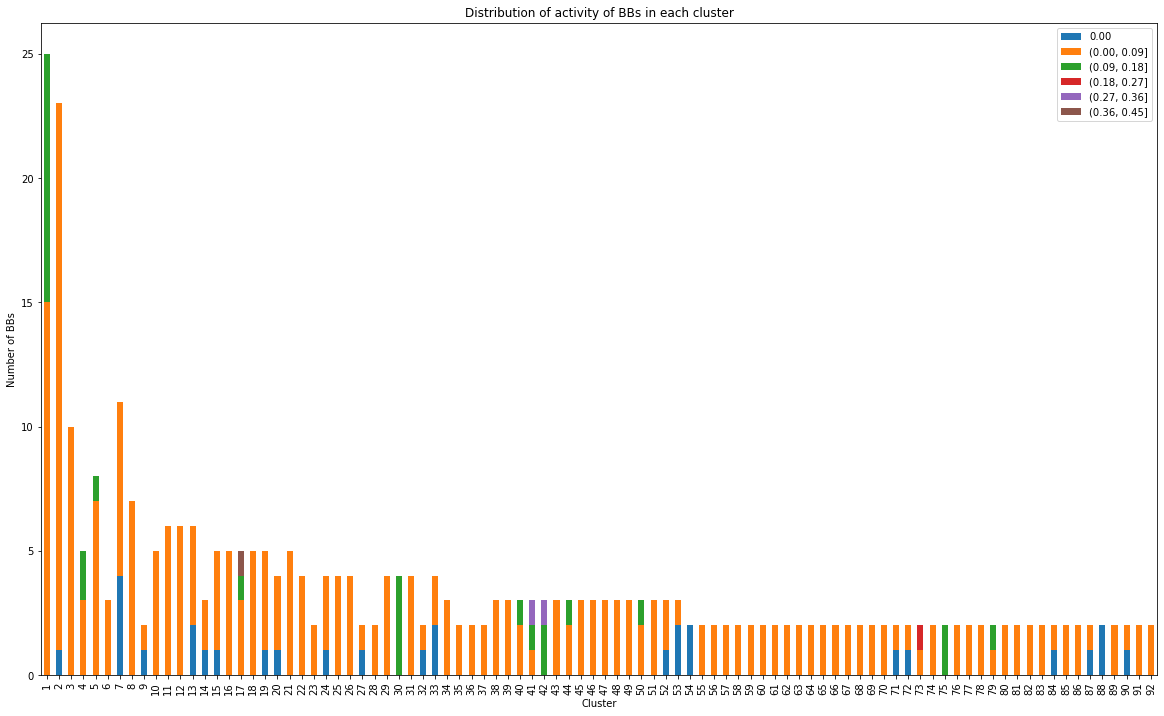

In [19]:
helper.stacked_plots(butina_bb1_3D_data, bins_x=True, logy=False)
helper.stacked_plots(butina_bb1_3D_data, bins_x=False, logy=False)

In [20]:
mols2grid.display(butina_bb1_3D_clusters, subset=['Cluster', 'img', 'Num'])

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/mols2grid/select.py:26: UserWarning: Overwriting non-empty 'default' grid selection: {1: 'C(C#N)[C@H](C(=O)O)N'}
  f"Overwriting non-empty {name!r} grid selection: {str(overwrite)}"


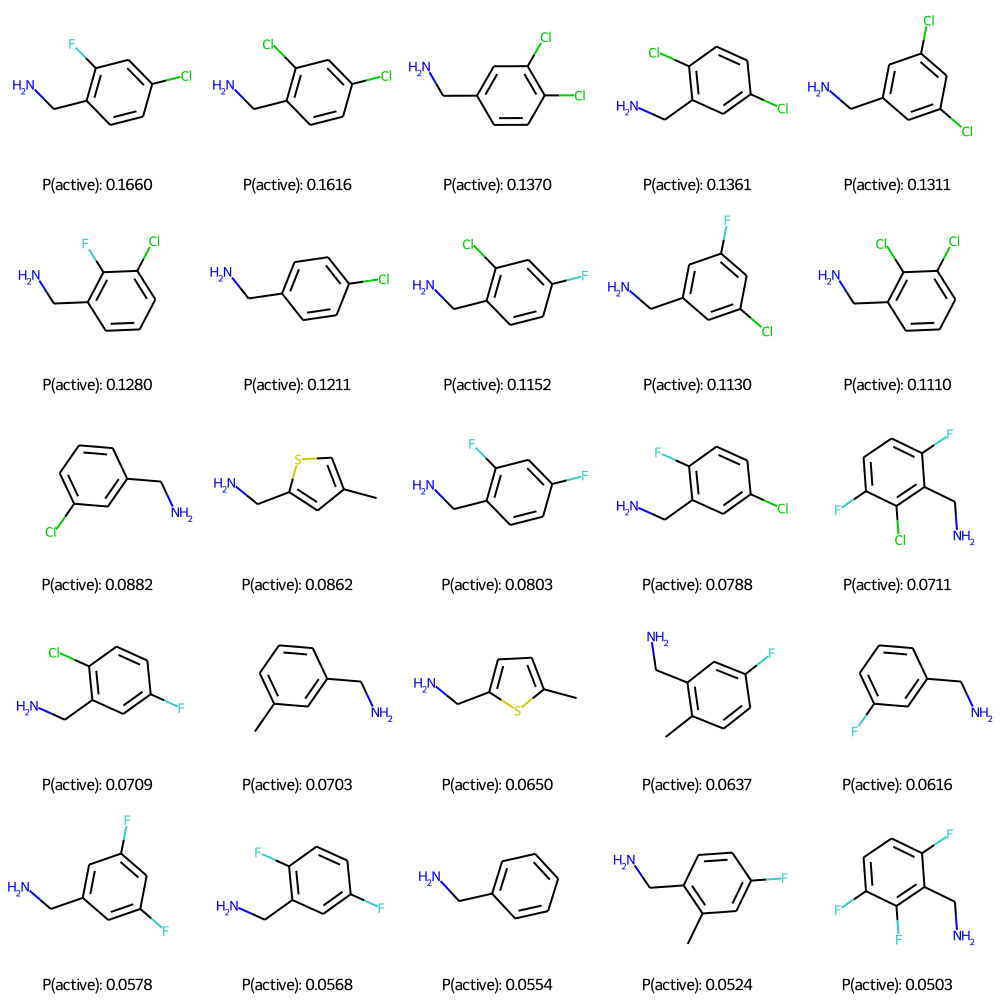

In [23]:
butina_sel = mols2grid.get_selection()
helper.display_cluster_members(butina_bb1_3D_data, butina_sel, align_mcs=False)

### Some quick notes

- In all of these clustering parameterizations, we end up classifying a lot of compounds as noise. This is not super optimal, but using too many points compromises the quality of the clustering. 

- We are displaying the stereo_SMILES for each building block. It turns out that there are some building blocks in the dataset that were reported as both a racemic mixture and as a single stereoisomer. After we enumerate stereoisomers and choose the best fitting stereoisomer, the racemic mixture is represented by a stereoisomer that is already reported individually. This should not be a large concern and in cases where this does appear, the resultant P(active) values seem quite consistent. 